# Flanker vs Task Switching

For the sake of readability, the global imports will be at the top. I also decided to keep the function names and explain what they do as it relates to the broader project. In my visual studio code I organized my project in four seperate files which handle each part of the process relating to my code. I included them here to show how I have my code organized.

In [131]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

# Config File

Replace the following strings with your path containing the flanker and task switching participant data. Addionally filter out the columns of interest below that.

In [132]:
directory = 'C:/Users/jlvdb/OneDrive/Desktop/LifespanDDM_Data/'
Flanker_Folder = 'flanker/'
Task_Switching_Folder = 'task_switching/'

get_columns_Flanker = ['rt', 'acc', 'reward', 'prop_cong']
get_columns_Task_Switching = ['rt', 'acc','reward','switch_rate']

For this project the columns of interest are the reaction times, accuracy, reward and difficulty (proportion congruence for the Flanker task and switch rate for the Task Switching task).

# Datacleaning

Since we have files from two folders that we want to combine, we have to clean the data with the goal to combine them all into one big dataframe (or excel spreadsheet). The first few functions will deal with picking out columns of interest and then the last function will put everything together. We will go through this function by function explaining what everything does.

This first function 'get_file_path', finds the files in both folders in our directory that have the corresponding 'unique_id' that we ask it to look for. With our dataset the 'unique_id' coresponds to the participant ID since the name of the file is based off the participant ID. 

In [133]:
def get_file_path(directory, folder, unique_id):
    path = os.path.join(directory, folder, f'*{unique_id}*.csv')
    return glob.glob(path)

Although it is not entirely clear as of just yet, in terms of how we do this with every file. Just remember that we are laying down the foundation with these first few functions and then combining them all at the end. 

The next function 'get_participant_info' looks for the age and sex of the participant on only the first row and returns this info.

In [134]:
def get_participant_info(file_path):
    df_info = pd.read_csv(file_path, nrows=1)
    return df_info['age'][0], df_info['sex'][0]

This next function 'create_info_df' takes the unique_id which we gave in the 'get_file_path' and the participant age and sex which we got from the function 'get_participant_info' and returns it into a Dataframe (like an internal excel spreadsheet).

In [135]:
def create_info_df(unique_id, participant_age, participant_sex):
    return pd.DataFrame({
                'Participant ID': [unique_id],
                'Age': [participant_age],
                'Sex': [participant_sex],
            })

This function filters out data and starts the preperation of preparing the combined dataframe with all participants. We take the file path, columns of interest, task name (flanker and taskswitching) and the unique id and do this for every partcipant. 

Here, we filter out all trials that are not the main phase. This includes practice and baseline trials. Furthermore, we filter out only the columns of interest which we stated in our config file. 

We also dropped rows where there is an absent accuracy value. Since we know that accuracy values will always be included in the dataframe even when the participant does not answer (will be recorded as a 0 for incorrect), it serves to cut off the end of the dataframe from including empty rows.

In the original flanker and task switching files, the participant trial numbers were not recorded so we included them here for clarity.

Lastly, we renamed the difficulty for both flanker and task switching to more readable names for clarity.

In [136]:
def read_and_prepare_new_df(file_path, columns, task_name, unique_id):
    df = pd.read_csv(file_path)
    
    # Filter rows where phase is 'main'
    df = df[df['phase'] == 'main']
    # Keep only the desired columns
    df = df[columns] 
    
    # Removes rows where 'acc' is NaN or empty
    df = df.dropna(subset=['acc'])

    # Adds task trial number in new dataframe
    df.insert(0, f'{task_name} Trial', range(1, df['acc'].count() + 1))

    # Rename prop_cong/switch_rate to difficulty_Flanker/difficulty_Task_Switching
    if task_name == 'Flanker':
        df = df.rename(columns={'prop_cong': 'Proportion Congruent'})
    elif task_name == 'Task Switching':
        df = df.rename(columns={'switch_rate': 'Switch Rate'})

    return df

This function serves to save our dataframes that we create into an excel file. The for loop makes it so that the cells are spaced out enough so the wording does not get cut off, so that we read everything cleanly at first glance when opening the spreadsheet.

In [137]:
def save_to_excel(writer, df, sheet_name):
    df.to_excel(writer, index=False, sheet_name=sheet_name)
    worksheet = writer.sheets[sheet_name]

    # formats the columns to make the excel file more readable
    for idx, col in enumerate(df): 
        series = df[col]
        max_len = max((
            series.astype(str).map(len).max(),
            len(str(series.name))  
            )) + 1  
        worksheet.set_column(idx, idx, max_len)

The prepare_data function is the big function that combines all the information gathered from preceding functions to create one big combined dataframe and spreadsheet. 

We create an empty list called dataframes to store all the participant data. We then cycle through each participant that we have for both flanker and task switching. 

If there is a matching file with the 'unique id', we start extracting the data from each file. We first get the participant age and sex from the flanker file. It does not matter if we get it from the flanker or taskswitching file since the age and sex will be the same, so we just get it from flanker to make it easy.

We take the info from 'create_info_df' (id, age and sex) and put it into df_info. We then take the columns of interest in the flanker file and the task switching file and put it into df_flanker and df_taskswitching respectively. 

Before concatenating all the info together we have to reset the index for all three variables that we stored our info into or else we get weird spacing errors with our dataframe and spreadsheet. Finally, we concat (put the information all together horizonatlly) in a new dataframe'df'. When we append the dataframe we then include all the dataframes from all participants together vertically. 

To make it easier and more straightforward for data modeling, I filled all the empty spaces of partcipant ID, age and sex all the way down until the value changes. Age and sex are not all that neccesary considering we will not be viewing any random effects related to these variables but I included them just in case if we wanted to see any potential relationships.

In [138]:
def prepare_data():
    dataframes = []
    for unique_id in range(10001, 10068): 
        csv_files_Flanker = get_file_path(directory, Flanker_Folder, unique_id)
        csv_files_Task_Switching = get_file_path(directory, Task_Switching_Folder, unique_id)

        if csv_files_Flanker and csv_files_Task_Switching:
            participant_age, participant_sex = get_participant_info(csv_files_Flanker[0])

            df_info = create_info_df(unique_id, participant_age, participant_sex)
            
            df_flanker = read_and_prepare_new_df(csv_files_Flanker[0], get_columns_Flanker, 'Flanker', unique_id)
            df_flanker = df_flanker.rename(columns={'rt': 'rt_Flanker', 'reward': 'reward_Flanker', 'acc': 'acc_Flanker'})

            df_taskswitching = read_and_prepare_new_df(csv_files_Task_Switching[0], get_columns_Task_Switching, 'Task Switching', unique_id)
            df_taskswitching = df_taskswitching.rename(columns={'rt': 'rt_Task_Switching', 'reward': 'reward_Task_Switching', 'acc': 'acc_Task_Switching'}) 

            # Reset the indexes of each dataframe before concatenating
            df_info.reset_index(drop=True, inplace=True)
            df_flanker.reset_index(drop=True, inplace=True)
            df_taskswitching.reset_index(drop=True, inplace=True)

            df = pd.concat([df_info, df_flanker, df_taskswitching], axis=1)

            dataframes.append(df)
            
            df['Participant ID'] = df['Participant ID'].ffill()
            df['Age'] = df['Age'].ffill()
            df['Sex'] = df['Sex'].ffill()
            
    combined_df = pd.concat(dataframes, ignore_index=True)
    return dataframes, combined_df

dataframes, combined_df = prepare_data()

Now we want to know if our functioned processed the data properly. Below we printed out the first four lines of the dataframe, and all of this looks good so far. As we can see we got all of our columns of interest, trial number and everything else we stated we were interested in.

In [140]:
print(combined_df.head())

   Participant ID   Age Sex  Flanker Trial  rt_Flanker  acc_Flanker  \
0         10001.0  20.0   F              1    0.663471            1   
1         10001.0  20.0   F              2    0.467196            1   
2         10001.0  20.0   F              3    0.542136            1   
3         10001.0  20.0   F              4    0.502783            1   
4         10001.0  20.0   F              5    0.545072            1   

   reward_Flanker  Proportion Congruent  Task Switching Trial  \
0            10.0                   0.9                     1   
1            10.0                   0.9                     2   
2            10.0                   0.9                     3   
3            10.0                   0.9                     4   
4            10.0                   0.9                     5   

   rt_Task_Switching  acc_Task_Switching  reward_Task_Switching  Switch Rate  
0           1.342101                   1                    1.0          0.9  
1           1.191059    

To make absoulutely certain it carried through the whole dataframe we will print out the last four lines. As we can see, everything worked out well, and we have our combined dataframe with all of our participants for both the flanker task and the taskswitching task.

In [142]:
print(combined_df.tail(4))

       Participant ID   Age Sex  Flanker Trial  rt_Flanker  acc_Flanker  \
21436         10067.0  22.0   m            317    0.465338            1   
21437         10067.0  22.0   m            318    0.485139            1   
21438         10067.0  22.0   m            319    0.464306            1   
21439         10067.0  22.0   m            320    0.459644            1   

       reward_Flanker  Proportion Congruent  Task Switching Trial  \
21436             1.0                   0.1                   317   
21437             1.0                   0.1                   318   
21438             1.0                   0.1                   319   
21439             1.0                   0.1                   320   

       rt_Task_Switching  acc_Task_Switching  reward_Task_Switching  \
21436           0.847257                   1                   10.0   
21437           1.072687                   1                   10.0   
21438           0.674030                   1                   10

# Descriptive Statistics

Now that we have all of our data processed and cleaned (at least our main big dataframe), we can now begin data analysis. To start we will measure some descriptive statistics about our combined sample, and then into some plots to examine the relationships beteween reaction time, accuracy, difficulty and reward for the sample. 

In the following function we just take descriptive statistics of the data that we are interested in and return the values under 'stats'. IQR stands for inter-quartile range which captures the range of the middle 50% of the data.

In [143]:
def descriptive_statistics(df, skip_columns=[]):
    stats = {}
    for column in df.columns:
        if column not in skip_columns:
            stats[column] = {
                'mean': df[column].mean(),
                'median': df[column].median(),
                'std_dev': df[column].std(),
                'variance':df[column].var(),
                'iqr': df[column].quantile(0.75) - df[column].quantile(0.25),
                'skewness': df[column].skew(),
                'kurtosis': df[column].kurtosis()
            }
    return stats

Additionally, we want to see the mean for each participant in both tasks for reaction time and accuracy. This function returns these values under 'average_per_participant'.

In [144]:
def calculate_average_per_participant(df):
    cols_to_consider = ['rt_Flanker', 'rt_Task_Switching', 'acc_Flanker', 'acc_Task_Switching']
    average_per_participant = df.groupby('Participant ID')[cols_to_consider].mean()
    return average_per_participant

From the first two functions we create a huge spreadsheet with the big dataframe of all the participant data for both tasks on the first sheet. On the second sheet we have the descriptive statistics about the whole sample under the sheet name 'Statistics'. On the last sheet we have averages per participant under in the sheet 'Averages'. We reset the index to ensure everything is formatted properly.

Now we have this excel file saved in our directory.

In [145]:
def combined_statistics(df):
    skip_columns = ['Participant ID', 'Age', 'Sex', 'Flanker Trial', 'reward_Flanker', 'Task Switching Trial', 'reward_Task_Switching', 'Proportion Congruent', 'Switch Rate']
    stats = descriptive_statistics(df, skip_columns)

    stats_df = pd.DataFrame(stats)
    stats_df.index.name = 'Statistic'
    stats_df.reset_index(inplace=True)

    averages_df = calculate_average_per_participant(df)
    averages_df.reset_index(inplace=True)

    with pd.ExcelWriter(os.path.join(directory, 'Combined_Sample.xlsx'), engine='xlsxwriter') as writer:
        save_to_excel(writer, df, 'Data')
        save_to_excel(writer, stats_df, 'Statistics')
        save_to_excel(writer, averages_df, 'Averages')
    
combined_statistics(combined_df)

Now we can do proper analysis, starting with looking at histograms of the mean reaction times and accuracy for both tasks across participants. We create weights by dividing one of the participants avg values to the total amount of values for the variable that we are measuring. We do this for the variables, reaction time and accuracy of the flanker and task switching tasks. 

Afterwards we create the histograms based off these values into different bins. The output is our histograms based off these values (reaction time and accuracy for both tasks).

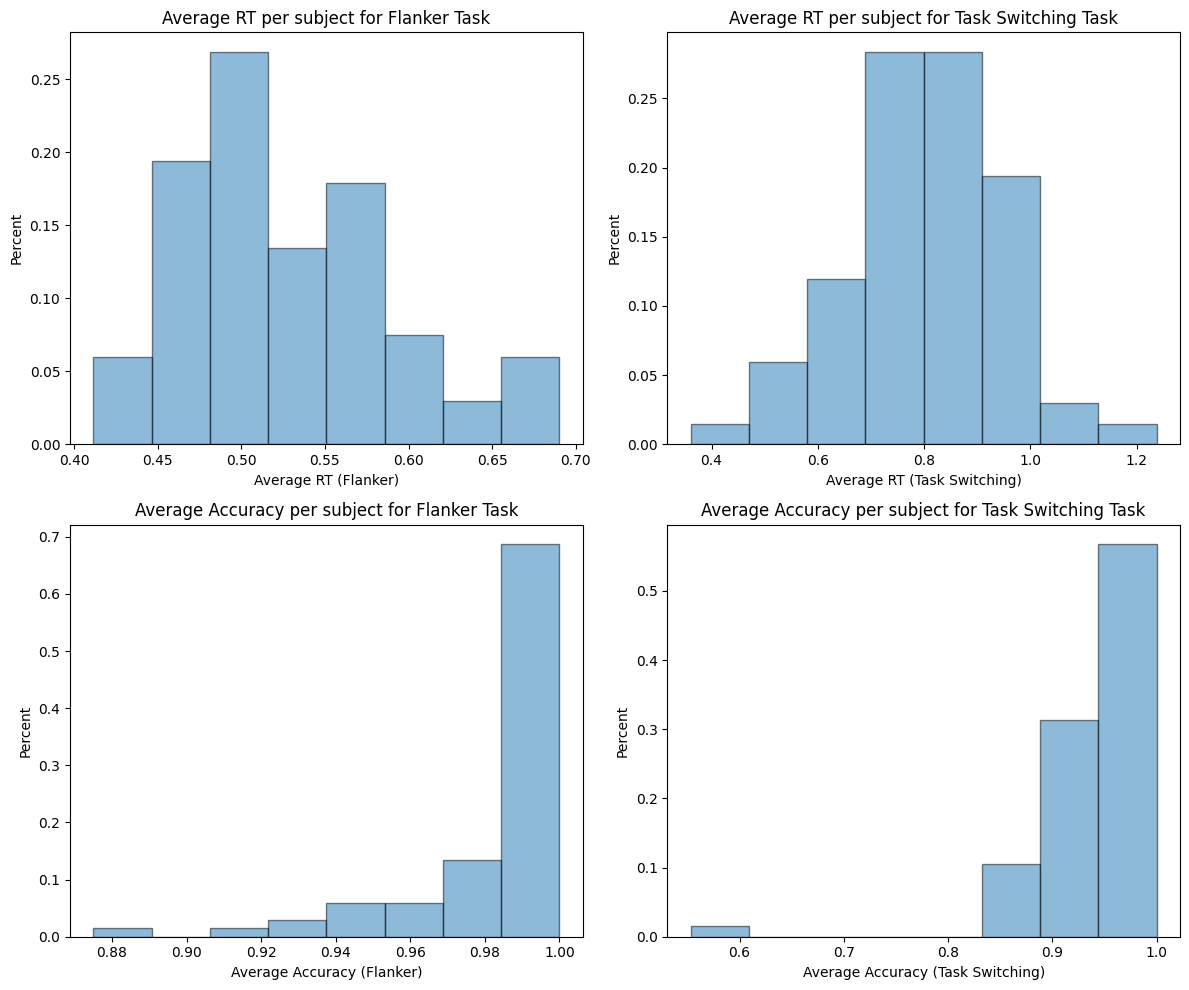

In [146]:
def plot_average_histograms(df):
    avg_rt_and_acc = df.groupby('Participant ID')[['rt_Flanker', 'rt_Task_Switching', 'acc_Flanker', 'acc_Task_Switching']].mean()

    # Create weights for all the histograms
    weights_rt_Flanker = np.ones_like(avg_rt_and_acc['rt_Flanker']) / len(avg_rt_and_acc['rt_Flanker'])
    weights_rt_Task_Switching = np.ones_like(avg_rt_and_acc['rt_Task_Switching']) / len(avg_rt_and_acc['rt_Task_Switching'])
    weights_acc_Flanker = np.ones_like(avg_rt_and_acc['acc_Flanker']) / len(avg_rt_and_acc['acc_Flanker'])
    weights_acc_Task_Switching = np.ones_like(avg_rt_and_acc['acc_Task_Switching']) / len(avg_rt_and_acc['acc_Task_Switching'])

    # Create the histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].hist(avg_rt_and_acc['rt_Flanker'], bins=8, alpha=0.5, edgecolor='black', weights=weights_rt_Flanker)
    axs[0, 0].set_xlabel('Average RT (Flanker)')
    axs[0, 0].set_ylabel('Percent')
    axs[0, 0].set_title('Average RT per subject for Flanker Task')

    axs[0, 1].hist(avg_rt_and_acc['rt_Task_Switching'], bins=8, alpha=0.5, edgecolor='black', weights=weights_rt_Task_Switching)
    axs[0, 1].set_xlabel('Average RT (Task Switching)')
    axs[0, 1].set_ylabel('Percent')
    axs[0, 1].set_title('Average RT per subject for Task Switching Task')

    axs[1, 0].hist(avg_rt_and_acc['acc_Flanker'], bins=8, alpha=0.5, edgecolor='black', weights=weights_acc_Flanker)
    axs[1, 0].set_xlabel('Average Accuracy (Flanker)')
    axs[1, 0].set_ylabel('Percent')
    axs[1, 0].set_title('Average Accuracy per subject for Flanker Task')

    axs[1, 1].hist(avg_rt_and_acc['acc_Task_Switching'], bins=8, alpha=0.5, edgecolor='black', weights=weights_acc_Task_Switching)
    axs[1, 1].set_xlabel('Average Accuracy (Task Switching)')
    axs[1, 1].set_ylabel('Percent')
    axs[1, 1].set_title('Average Accuracy per subject for Task Switching Task')

    fig.tight_layout()
    plt.savefig(f"{directory}/average_rt_acc_histograms.png")

plot_average_histograms(combined_df)

# Plots

Now we have a good idea of how our data is distributed for participants for accuracy in reaction time. Lets build on this and create plots that analyze different relationships in our dataset.

First lets see the average reaction time based on accuracy. This will give us a good idea of how accurate participants were for all total trials and tell us how the reaction time changed based on the accuracy of their response.

As we can see by the n values, participants were generally accurate for all the tasks especially the flanker task. Additionally, we see that accurate responses are on average slower than inaccurate responses, although this may not be entirely significant for the taskswitching considering their closeness in values (Incorrect=0.79s, Correct=0.81s). Also, there may not be enough samples to conclude anything for the flanker considering how seldomly participants answer incorrectly.

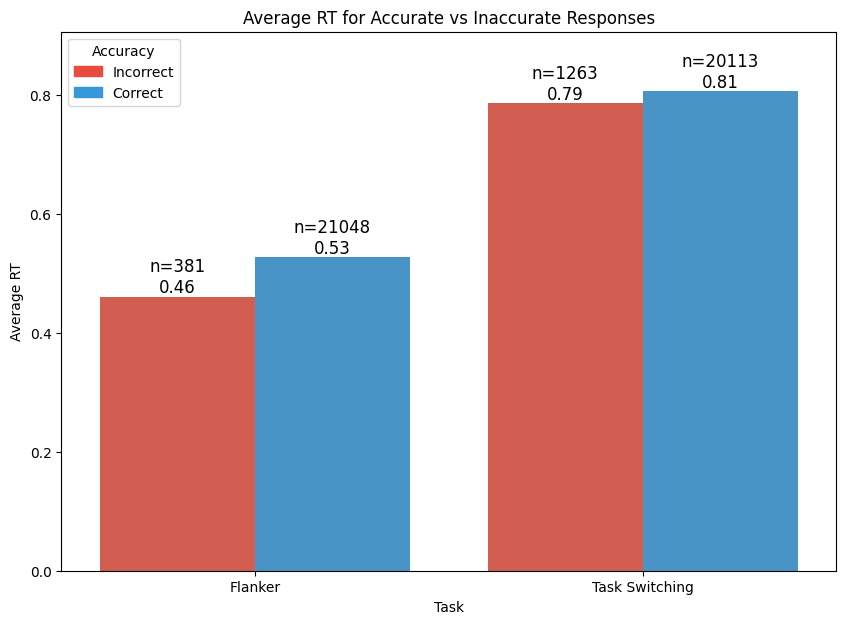

In [147]:
def plot_avg_rt_by_accuracy(df):

    # Grouping and aggregating data
    flanker = df[['rt_Flanker', 'acc_Flanker']].groupby('acc_Flanker').agg(['mean', 'count']).reset_index()
    flanker.columns = ['Accuracy', 'mean_RT', 'count']
    flanker['Task'] = 'Flanker'

    task_switching = df[['rt_Task_Switching', 'acc_Task_Switching']].groupby('acc_Task_Switching').agg(['mean', 'count']).reset_index()
    task_switching.columns = ['Accuracy', 'mean_RT', 'count']
    task_switching['Task'] = 'Task Switching'

    avg_rt_per_acc = pd.concat([flanker, task_switching], axis=0).reset_index(drop=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = sns.barplot(x='Task', y='mean_RT', hue='Accuracy', data=avg_rt_per_acc, palette=['#e74c3c', '#3498db'])
    
    # Set labels, title, and y-axis limit
    ax.set_xlabel('Task')
    ax.set_ylabel('Average RT')
    ax.set_title('Average RT for Accurate vs Inaccurate Responses')
    y_max = avg_rt_per_acc['mean_RT'].max() + 0.1
    ax.set_ylim(0, y_max)

    # Modify the legend
    legend_patches = [mpatches.Patch(color='#e74c3c', label='Incorrect'), 
                      mpatches.Patch(color='#3498db', label='Correct')]
    ax.legend(handles=legend_patches, title='Accuracy')
    
    # Annotating bars with 'n' values
    for index, row in avg_rt_per_acc.iterrows():
        x_position = (index // 2) + (-0.2 if row['Accuracy'] == 0 else 0.2)  # Adjust the position based on Accuracy
        ax.text(x_position, row['mean_RT'], f"n={row['count']}\n{row['mean_RT']:.2f}",
                ha="center", va="bottom", fontsize=12)
    
    # Save figure
    directory = '.'
    plt.savefig(f'{directory}/average_rt_per_accuracy.png')

plot_avg_rt_by_accuracy(combined_df)


Now lets compare the reaction times and accuracy of the each participants flanker and taskswitching tasks. In the first plot we compare the reaction time on the flanker task vs the reaction time of the task switching task for each participant. We already calculated the averages in the Averages sheet in our combined sample spreadsheet, so we just have to plot them accordingly. The next plot is the same but instead of reaction time it is for accuracy.

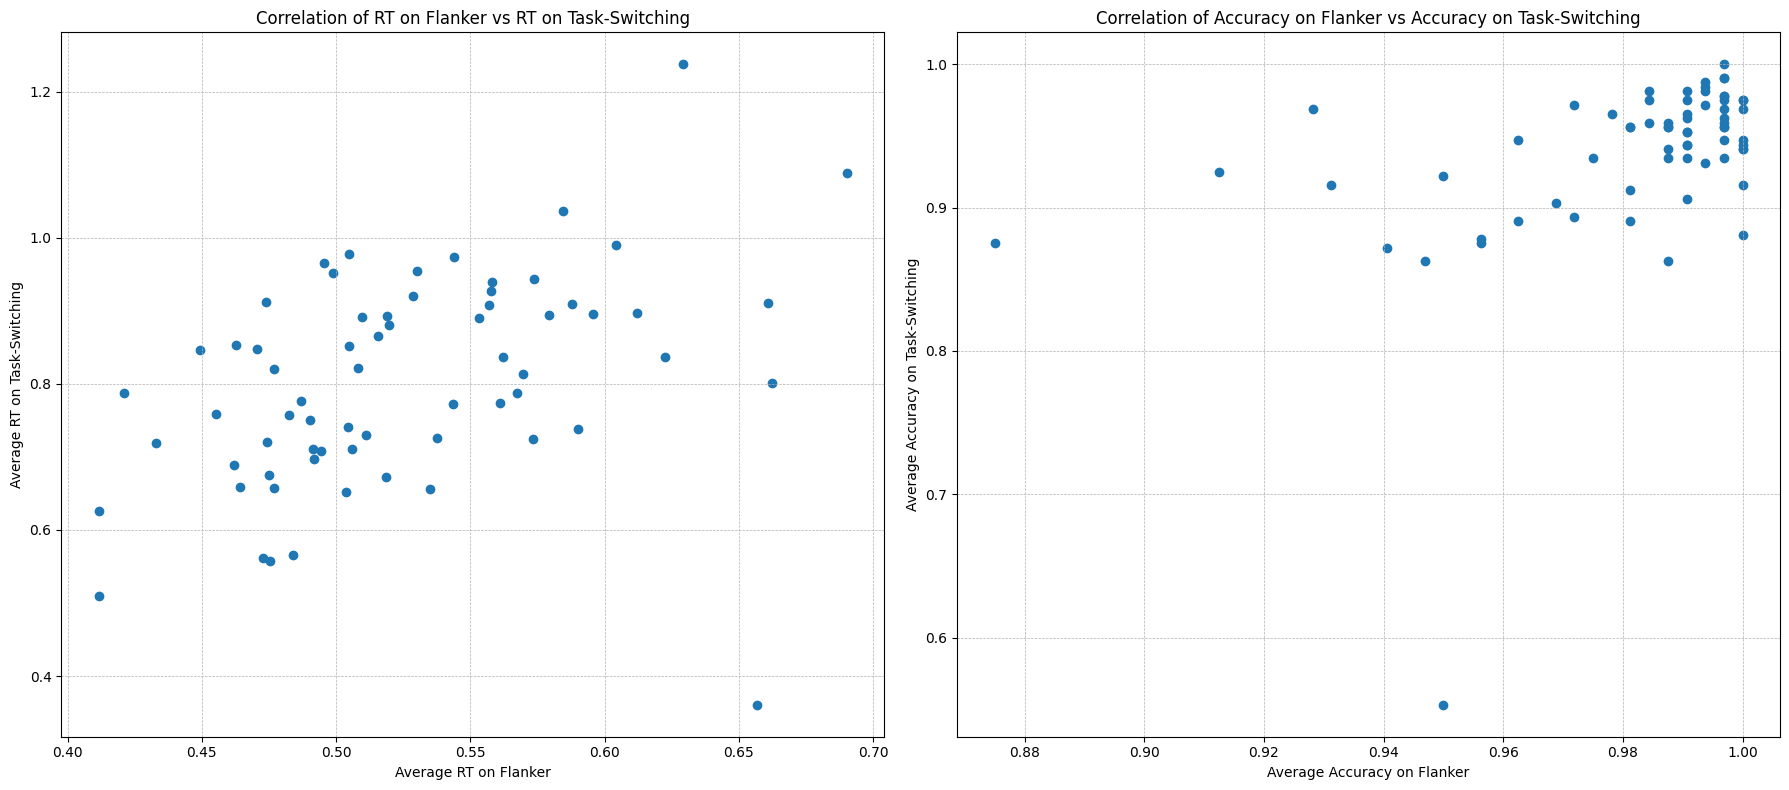

In [149]:
def plot_correlations_from_excel(directory):
    # Load data from Excel
    averages_df = pd.read_excel(directory + 'Combined_Sample.xlsx', sheet_name='Averages')

    # Create 2x1 subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # RT correlation plot
    axs[0].scatter(averages_df['rt_Flanker'], averages_df['rt_Task_Switching'])
    axs[0].set_xlabel('Average RT on Flanker')
    axs[0].set_ylabel('Average RT on Task-Switching')
    axs[0].set_title('Correlation of RT on Flanker vs RT on Task-Switching')
    axs[0].grid(True, linestyle='--', linewidth=0.5) 

    # Accuracy correlation plot
    axs[1].scatter(averages_df['acc_Flanker'], averages_df['acc_Task_Switching'])
    axs[1].set_xlabel('Average Accuracy on Flanker')
    axs[1].set_ylabel('Average Accuracy on Task-Switching')
    axs[1].set_title('Correlation of Accuracy on Flanker vs Accuracy on Task-Switching')
    axs[1].grid(True, linestyle='--', linewidth=0.5)
    
    # Adjust layout and save the figure
    fig.tight_layout()
    directory = '.'
    plt.savefig(f'{directory}/correlations.png')
    
plot_correlations_from_excel(directory)

This plot on the left looks at the average change in reaction time between the hard trials and easy trials for both tasks per participant. This is done to see the differences between participants when there is a change in difficulty. The right plot does the same thing but for accuracy, and its between easy and hard trials. The thought process is that accuracy will be higher at the lower difficulty level so we should subtract the hard difficulty level accuracy from it.

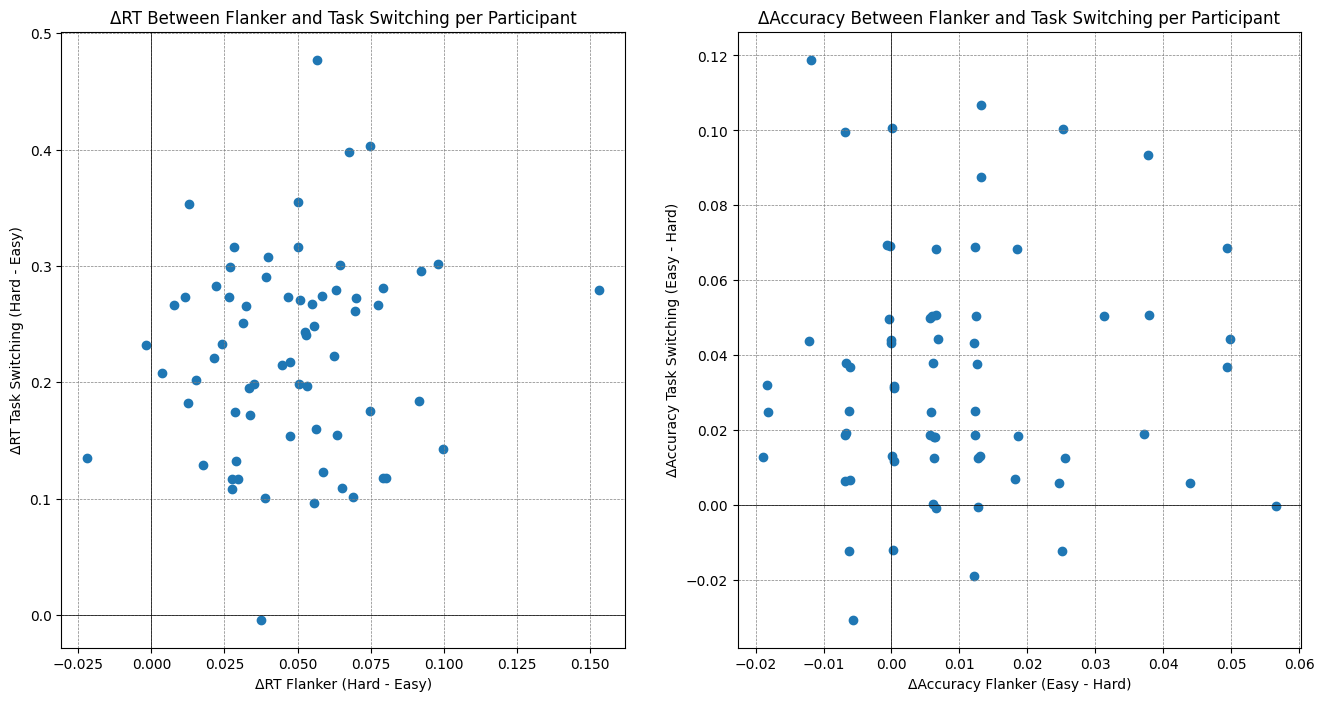

In [150]:
def delta_plot_correlations_from_excel(directory):
    # Load data
    df = pd.read_excel(directory + 'Combined_Sample.xlsx')

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
        
    # Compute mean RT per condition per participant for Flanker
    flanker_means = df.groupby(['Participant ID', 'Proportion Congruent'])['rt_Flanker'].mean().reset_index()
    flanker_pivot = flanker_means.pivot(index='Participant ID', columns='Proportion Congruent', values='rt_Flanker')
    flanker_pivot['delta_rt_flanker'] = flanker_pivot[0.1] - flanker_pivot[0.9]

    # Compute mean RT per condition per participant for Task Switching
    task_switching_means = df.groupby(['Participant ID', 'Switch Rate'])['rt_Task_Switching'].mean().reset_index()
    task_switching_pivot = task_switching_means.pivot(index='Participant ID', columns='Switch Rate', values='rt_Task_Switching')
    task_switching_pivot['delta_rt_task_switching'] = task_switching_pivot[0.9] - task_switching_pivot[0.1]

    # Merge the datasets
    merged = pd.merge(flanker_pivot, task_switching_pivot, on='Participant ID')

    # Create scatter plot
    axs[0].scatter(merged['delta_rt_flanker'], merged['delta_rt_task_switching'])
    axs[0].set_xlabel('ΔRT Flanker (Hard - Easy)')
    axs[0].set_ylabel('ΔRT Task Switching (Hard - Easy)')
    axs[0].set_title('ΔRT Between Flanker and Task Switching per Participant')
    axs[0].axhline(0, color='black',linewidth=0.5)
    axs[0].axvline(0, color='black',linewidth=0.5)
    axs[0].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    
    flanker_acc_means = df.groupby(['Participant ID', 'Proportion Congruent'])['acc_Flanker'].mean().reset_index()
    flanker_acc_pivot = flanker_acc_means.pivot(index='Participant ID', columns='Proportion Congruent', values='acc_Flanker')
    flanker_acc_pivot['delta_acc_flanker'] = flanker_acc_pivot[0.9] - flanker_acc_pivot[0.1]  # Easy - Hard

    # Compute mean accuracy per condition per participant for Task Switching
    task_switching_acc_means = df.groupby(['Participant ID', 'Switch Rate'])['acc_Task_Switching'].mean().reset_index()
    task_switching_acc_pivot = task_switching_acc_means.pivot(index='Participant ID', columns='Switch Rate', values='acc_Task_Switching')
    task_switching_acc_pivot['delta_acc_task_switching'] = task_switching_acc_pivot[0.1] - task_switching_acc_pivot[0.9]  # Easy - Hard

    # Merge the datasets
    merged = pd.merge(flanker_acc_pivot, task_switching_acc_pivot, on='Participant ID')

    # Add jitter to the points to avoid stacked datapoints
    jitter_amount = 0.0007  # adjust as needed
    merged['delta_acc_flanker_jittered'] = merged['delta_acc_flanker'] + np.random.uniform(low=-jitter_amount, high=jitter_amount, size=len(merged))
    merged['delta_acc_task_switching_jittered'] = merged['delta_acc_task_switching'] + np.random.uniform(low=-jitter_amount, high=jitter_amount, size=len(merged))

    # Create scatter plot with jittered points
    axs[1].scatter(merged['delta_acc_flanker_jittered'], merged['delta_acc_task_switching_jittered'])
    axs[1].set_xlabel('ΔAccuracy Flanker (Easy - Hard)')
    axs[1].set_ylabel('ΔAccuracy Task Switching (Easy - Hard)')
    axs[1].set_title('ΔAccuracy Between Flanker and Task Switching per Participant')
    axs[1].axhline(0, color='black',linewidth=0.5)
    axs[1].axvline(0, color='black',linewidth=0.5)
    axs[1].grid(color='gray', linestyle='--', linewidth=0.5)
    
    # Save the figure
    directory = '.'
    plt.savefig(f'{directory}/participant_delta_accuracy_scatter.png')
    plt.show()
    
delta_plot_correlations_from_excel(directory)

Uses participant averages for the plot below. There are no differences in the actual means of the plot and it allows me to create more conservative confidence intervals.

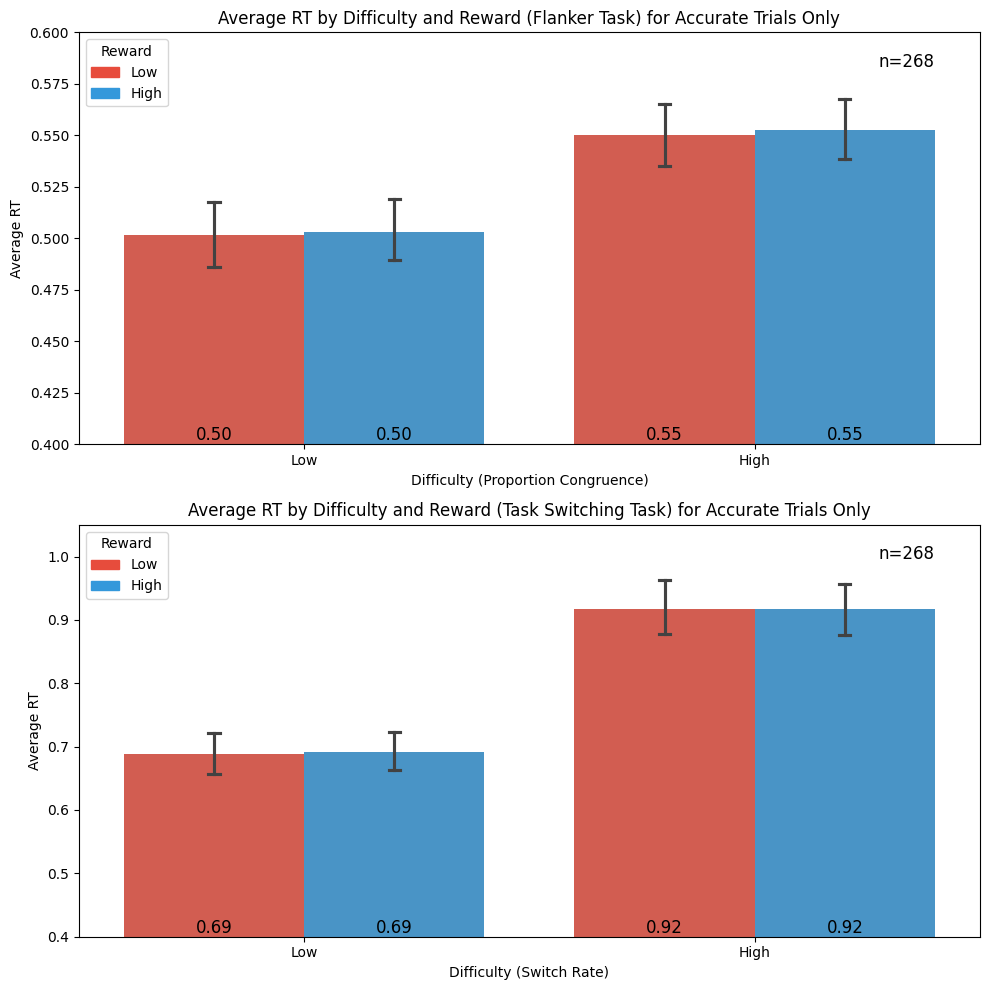

In [151]:
def plot_avg_rt_by_difficulty_and_reward_per_participant(df):
    # Filter df to only include correct trials for each task
    flanker_df = df[df['acc_Flanker'] == 1]
    task_switch_df = df[df['acc_Task_Switching'] == 1]
    
    # Group data by difficulty and reward condition
    flanker_df = flanker_df.groupby(['Participant ID', 'Proportion Congruent', 'reward_Flanker'])['rt_Flanker'].mean().reset_index()
    task_switch_df = task_switch_df.groupby(['Participant ID', 'Switch Rate', 'reward_Task_Switching'])['rt_Task_Switching'].mean().reset_index()
    
    # Replace difficulty levels
    task_switch_difficulty_mapping = {
        0.1: 'Low',
        0.9: 'High'
    }
    flanker_difficulty_mapping = {
        0.1: 'High',
        0.9: 'Low'
    }
    
    # Define a custom color palette
    custom_palette = {
        'Low': '#e74c3c',  # Red
        'High': '#3498db'   # Blue
    }
    
    flanker_df['Proportion Congruent'] = flanker_df['Proportion Congruent'].replace(flanker_difficulty_mapping)
    task_switch_df['Switch Rate'] = task_switch_df['Switch Rate'].replace(task_switch_difficulty_mapping)

    # Replace reward levels
    reward_mapping = {
        1: 'Low',
        10: 'High'
    }
    
    flanker_df['reward_Flanker'] = flanker_df['reward_Flanker'].replace(reward_mapping)
    task_switch_df['reward_Task_Switching'] = task_switch_df['reward_Task_Switching'].replace(reward_mapping)
        
    # plot the two tasks
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    # Modify the legend
    legend_patches = [mpatches.Patch(color=custom_palette['Low'], label='Low'), 
                      mpatches.Patch(color=custom_palette['High'], label='High')]

    # plot for Flanker Task
    barplot1 = sns.barplot(x='Proportion Congruent', y='rt_Flanker', hue='reward_Flanker', data=flanker_df, ax=axs[0], palette=custom_palette, errorbar=('ci', 95), capsize=.05, order=['Low', 'High'])
    axs[0].set_title('Average RT by Difficulty and Reward (Flanker Task) for Accurate Trials Only')
    axs[0].set_xlabel('Difficulty (Proportion Congruence)')
    axs[0].set_ylabel('Average RT')
    axs[0].set_ylim(0.4, 0.60)
    axs[0].legend(handles=legend_patches, title='Reward',  loc ='upper left')
    axs[0].text(0.95, 0.95, 'n=268', transform=axs[0].transAxes, ha='right', va='top', fontsize=12)
    
    # Add labels on top of bars
    for p in barplot1.patches:
        height = p.get_height()
        if height > 0:  # Only label bars with a height greater than 0
            barplot1.text(p.get_x() + p.get_width() / 2., 0.4, '{0:.2f}'.format(height), 
                fontsize=12, ha='center', va='bottom')


    
    # plot for Task Switching Task
    barplot2 = sns.barplot(x='Switch Rate', y='rt_Task_Switching', hue='reward_Task_Switching', data=task_switch_df, ax=axs[1], palette=custom_palette, errorbar=('ci', 95), capsize=.05)
    axs[1].set_title('Average RT by Difficulty and Reward (Task Switching Task) for Accurate Trials Only')
    axs[1].set_xlabel('Difficulty (Switch Rate)')
    axs[1].set_ylabel('Average RT')
    axs[1].set_ylim(0.4, 1.05)
    axs[1].legend(handles=legend_patches, title='Reward', loc ='upper left')
    axs[1].text(0.95, 0.95, 'n=268', transform=axs[1].transAxes, ha='right', va='top', fontsize=12)
    
    # Add labels on top of bars
    for p in barplot2.patches:
        height = p.get_height()
        if height > 0:  # Only label bars with a height greater than 0
            barplot2.text(p.get_x() + p.get_width() / 2., 0.4, '{0:.2f}'.format(height), 
                fontsize=12, ha='center', va='bottom')
    
    plt.tight_layout()
    directory = '.'
    plt.savefig(f'{directory}/average_rt_by_difficulty_and_reward.png')
    
plot_avg_rt_by_difficulty_and_reward_per_participant(combined_df)

Same as before. Used participant averages for the plot below. There are no differences in the actual means of the plot and it allows me to create more conservative confidence intervals.

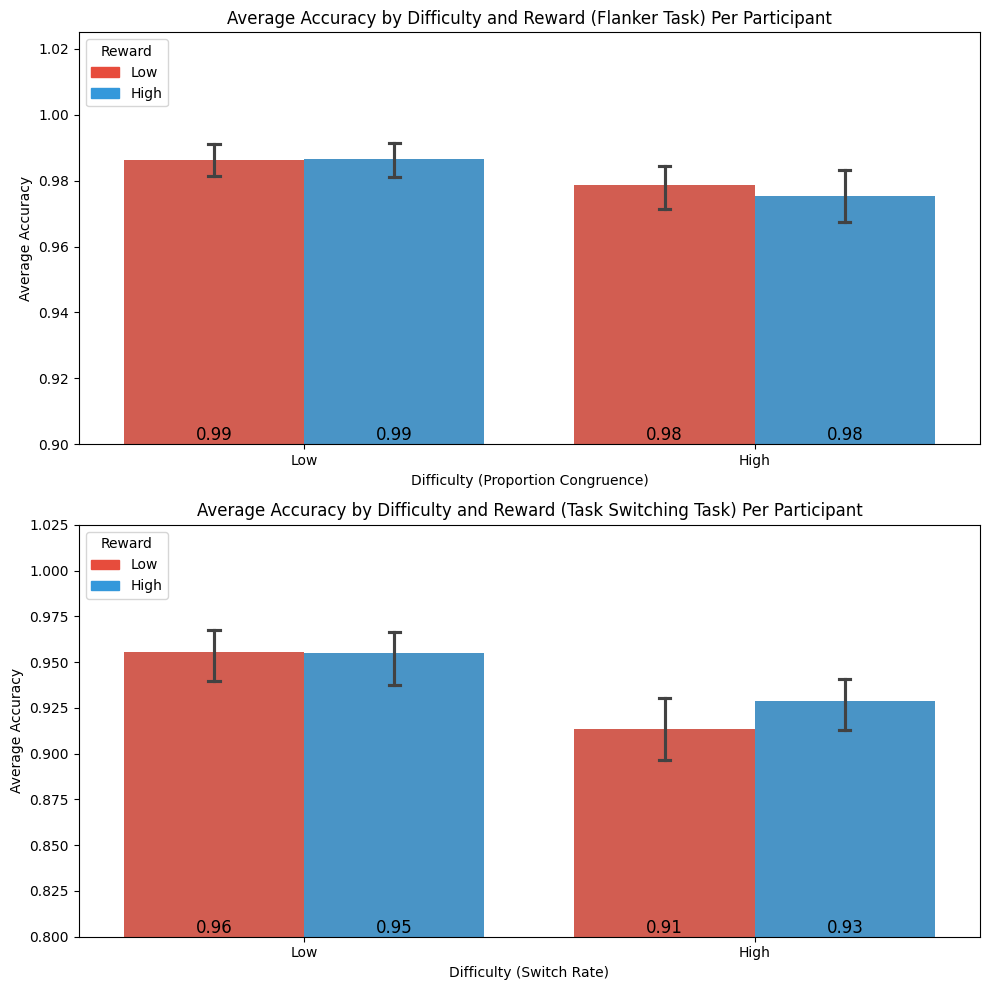

In [152]:
def plot_avg_accuracy_by_difficulty_and_reward_per_participant(df):
    # Group data by difficulty and reward condition per participant
    flanker_df = df.groupby(['Participant ID', 'Proportion Congruent', 'reward_Flanker'])['acc_Flanker'].mean().reset_index()
    task_switch_df = df.groupby(['Participant ID', 'Switch Rate', 'reward_Task_Switching'])['acc_Task_Switching'].mean().reset_index()

    # Replace difficulty levels
    task_switch_difficulty_mapping = {
        0.1: 'Low',
        0.9: 'High'
    }
    flanker_difficulty_mapping = {
        0.1: 'High',
        0.9: 'Low'
    }
    
    # Define a custom color palette
    custom_palette = {
        'Low': '#e74c3c',  # Red
        'High': '#3498db'   # Blue
    }
    
    flanker_df['Proportion Congruent'] = flanker_df['Proportion Congruent'].replace(flanker_difficulty_mapping)
    task_switch_df['Switch Rate'] = task_switch_df['Switch Rate'].replace(task_switch_difficulty_mapping)

    # Replace reward levels
    reward_mapping = {
        1: 'Low',
        10: 'High'
    }
    
    flanker_df['reward_Flanker'] = flanker_df['reward_Flanker'].replace(reward_mapping)
    task_switch_df['reward_Task_Switching'] = task_switch_df['reward_Task_Switching'].replace(reward_mapping)

    # plot the two tasks
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    # Modify the legend
    legend_patches = [mpatches.Patch(color=custom_palette['Low'], label='Low'), 
                      mpatches.Patch(color=custom_palette['High'], label='High')]

    # plot for Flanker Task
    barplot1 = sns.barplot(x='Proportion Congruent', y='acc_Flanker', hue='reward_Flanker', data=flanker_df, ax=axs[0], palette=custom_palette, errorbar=('ci', 95), capsize=.05, order=['Low', 'High'])
    axs[0].set_title('Average Accuracy by Difficulty and Reward (Flanker Task) Per Participant')
    axs[0].set_xlabel('Difficulty (Proportion Congruence)')
    axs[0].set_ylabel('Average Accuracy')
    axs[0].legend(handles=legend_patches, title='Reward',  loc ='upper left')
    axs[0].set_ylim(0.9, 1.025)
    
    # Add labels on top of bars
    for p in barplot1.patches:
        height = p.get_height()
        if height > 0:  # Only label bars with a height greater than 0
            barplot1.text(p.get_x() + p.get_width() / 2., 0.9, '{0:.2f}'.format(height), 
                fontsize=12, ha='center', va='bottom')
    
    # plot for Task Switching Task
    barplot2 = sns.barplot(x='Switch Rate', y='acc_Task_Switching', hue='reward_Task_Switching', data=task_switch_df, ax=axs[1], palette=custom_palette, errorbar=('ci', 95), capsize=.05, order=['Low', 'High'])
    axs[1].set_title('Average Accuracy by Difficulty and Reward (Task Switching Task) Per Participant')
    axs[1].set_xlabel('Difficulty (Switch Rate)')
    axs[1].set_ylabel('Average Accuracy')
    axs[1].legend(handles=legend_patches, title='Reward', loc ='upper left')
    axs[1].set_ylim(0.8, 1.025)
    
    # Add labels on top of bars
    for p in barplot2.patches:
        height = p.get_height()
        if height > 0:  # Only label bars with a height greater than 0
            barplot2.text(p.get_x() + p.get_width() / 2., 0.8, '{0:.2f}'.format(height), 
                fontsize=12, ha='center', va='bottom')
    
    plt.tight_layout()
    directory = '.'
    plt.savefig(f'{directory}/average_accuracy_by_difficulty_and_reward_per_participant.png')

# Replace combined_df with the actual dataframe you're using
plot_avg_accuracy_by_difficulty_and_reward_per_participant(combined_df)


# Regression

For our regression we have to make some changes to our dataframe. To calculate the difficulty and reward as categorical variables we change their values to 0 and 1 (0 being low and 1 being high). One difference you may see is that in Proportion Congruent, we change 0.1 to 1 and and 0.9 to 0. This is because a low proportion congruence is actually harder than an a higher proportion congruence for the Flanker task.

This function saves both regression results and we print them below.

In [156]:
def mult_regression(df):
    
    # Change categorical variables to 0 and 1
    df['updated_Proportion_Congruent'] = np.where(df['Proportion Congruent'] == 0.1, 1, np.where(df['Proportion Congruent'] == 0.9, 0, df['Proportion Congruent']))
    df['updated_Switch_Rate'] = np.where(df['Switch Rate'] == 0.1, 0, np.where(df['Switch Rate'] == 0.9, 1, df['Switch Rate']))
        
    df['updated_Reward_Flanker'] = np.where(df['reward_Flanker'] == 1, 0, np.where(df['reward_Flanker'] == 10, 1, df['reward_Flanker']))
    df['updated_Reward_Task_Switching'] = np.where(df['reward_Task_Switching'] == 1, 0, np.where(df['reward_Task_Switching'] == 10, 1, df['reward_Task_Switching']))

    grouped_df_flanker = df.groupby(['Participant ID', 'updated_Proportion_Congruent', 'updated_Reward_Flanker'])['rt_Flanker'].mean().reset_index()
    grouped_df_task_switching = df.groupby(['Participant ID', 'updated_Switch_Rate', 'updated_Reward_Task_Switching'])['rt_Task_Switching'].mean().reset_index()

    # Print 
    grouped_df_flanker.to_excel(f'{directory}grouped_flanker_data.xlsx', index=False)
    grouped_df_task_switching.to_excel(f'{directory}grouped_task_switching_data.xlsx', index=False)

    # Get Regression
    mod_Flanker = smf.ols("rt_Flanker ~ (updated_Proportion_Congruent) * (updated_Reward_Flanker)", data=grouped_df_flanker)
    res_Flanker = mod_Flanker.fit()

    mod_Task_Switching = smf.ols("rt_Task_Switching ~ (updated_Switch_Rate) * (updated_Reward_Task_Switching)", data=grouped_df_task_switching)
    res_Task_Switching = mod_Task_Switching.fit()

    # Get the summary text from the regression result
    summary_text_Flanker = res_Flanker.summary().as_text()
    summary_text_Task_Switching = res_Task_Switching.summary().as_text()

    # Write the summaries to individual text files
    with open(f'{directory}/summary_Flanker.txt', 'w') as file:
        file.write(summary_text_Flanker)
    with open(f'{directory}/summary_Task_Switching.txt', 'w') as file:
        file.write(summary_text_Task_Switching)

    return grouped_df_flanker, grouped_df_task_switching, summary_text_Flanker, summary_text_Task_Switching
    
grouped_df_flanker, grouped_df_task_switching, summary_text_Flanker, summary_text_Task_Switching = mult_regression(combined_df)

Lets interpret the summary below together. We use OLS method to calculate the regression with 268 observations (4 each for 67 participants). 

The intercept coeficient (0.5012) is the average reaction time of all participants when difficulty and reward is low. The associated t statistic and p-value (63.167, 0.000) are a bit misleading because it measures the significance compared to 0. However, this coefficient serves as a baseline to see how significantly the other variables alter the reaction time of participants. The 95% confidence interval [0.025, 0.975] is the measure of how confidently we can assume the population statistic given our sample. In this case we can assume with 95% confidence that our true population statistic lies between 0.486 and 0.517 seconds. 

I will not mention all the numbers in the table, however, some important ones are the values for updated_Proportion_Congruent. We can see that an increase in difficulty when reward is unchanged at low reward, on average increases the response time by ~0.05 seconds which is significant according to the p-value (p < 0.000). Additionally, an increase in reward does not seem to increase reaction time significantly.

In [127]:
print(summary_text_Flanker)

                            OLS Regression Results                            
Dep. Variable:             rt_Flanker   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     12.16
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           1.76e-07
Time:                        00:37:47   Log-Likelihood:                 354.49
No. Observations:                 268   AIC:                            -701.0
Df Residuals:                     264   BIC:                            -686.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

The same meaning for the statistics in Task Switching apply. The interesting part about these results is that the coefficient is noticably higher at 0.69 seconds and the increase in difficulty (updated_Switch_Rate) seems to on average increase the response time significantly when reward stays constant at low reward by ~0.29 seconds in our sample (p < 0.000). Similar to the Flanker task, the increase in reward when difficulty stays low insignificantly changes reaction time.

In [128]:
print(summary_text_Task_Switching)

                            OLS Regression Results                            
Dep. Variable:      rt_Task_Switching   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     46.79
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.78e-24
Time:                        00:37:47   Log-Likelihood:                 121.59
No. Observations:                 268   AIC:                            -235.2
Df Residuals:                     264   BIC:                            -220.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

This relationship in the regression summaries above can be shown with the plot below. We can see how difficulty significantly changes reaction time when comparing the 95% confidence intervals with each other. Additionally, we can visualize the insignificant interaction effects with the high difficulty and high reward bar remaining unchanged compared to the high difficulty low reward bar for both tasks.

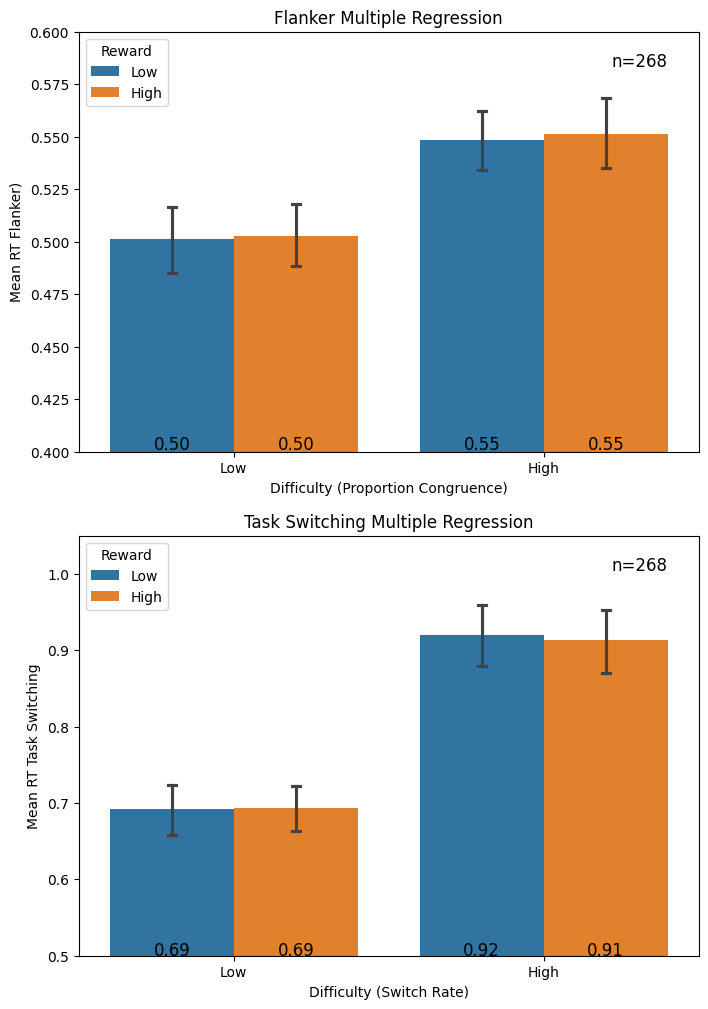

In [157]:
def visualized_multregression(grouped_df_flanker, grouped_df_task_switching):

    vis_grouped_df_flanker = grouped_df_flanker.copy()
    vis_grouped_df_task_switching = grouped_df_task_switching.copy()
    
    vis_grouped_df_flanker['Difficulty'] = vis_grouped_df_flanker['updated_Proportion_Congruent'].replace({0.0: 'Low', 1.0: 'High'})
    vis_grouped_df_flanker['Reward'] = vis_grouped_df_flanker['updated_Reward_Flanker'].replace({0.0: 'Low', 1.0: 'High'})
    
    # Modifying columns for visualization in Task Switching df
    vis_grouped_df_task_switching['Difficulty'] = vis_grouped_df_task_switching['updated_Switch_Rate'].replace({0.0: 'Low', 1.0: 'High'})
    vis_grouped_df_task_switching['Reward'] = vis_grouped_df_task_switching['updated_Reward_Task_Switching'].replace({0.0: 'Low', 1.0: 'High'})

    # Create a 2-panel figure: 2 rows, 1 column
    plt.figure(figsize=(8, 12))
    plt.subplot(2, 1, 1)
    
    ax1 = sns.barplot(x='Difficulty', y='rt_Flanker', hue='Reward', data=vis_grouped_df_flanker, errorbar=('ci', 95), capsize=.05, order=['Low', 'High'])
    ax1.legend(title='Reward', loc='upper left')
    ax1.text(0.95, 0.95, 'n=268', transform=ax1.transAxes, ha='right', va='top', fontsize=12)
    plt.xlabel('Difficulty (Proportion Congruence)')
    plt.ylabel('Mean RT Flanker)')
    plt.title('Flanker Multiple Regression')
    plt.ylim(0.4, 0.6)
    
    for p in ax1.patches:
        height = p.get_height()
        if height > 0:  # Only label bars with a height greater than 0
            ax1.text(p.get_x() + p.get_width() / 2., 0.408, '{0:.2f}'.format(height), 
                fontsize=12, ha='center', va='top')

    # Task Switching bar plot
    plt.subplot(2, 1, 2)
    ax2 = sns.barplot(x='Difficulty', y='rt_Task_Switching', hue='Reward', data=vis_grouped_df_task_switching, errorbar=('ci', 95), capsize=.05)
    ax2.legend(title='Reward', loc='upper left')
    ax2.text(0.95, 0.95, 'n=268', transform=ax2.transAxes, ha='right', va='top', fontsize=12)
    plt.xlabel('Difficulty (Switch Rate)')
    plt.ylabel('Mean RT Task Switching')
    plt.title('Task Switching Multiple Regression')
    plt.ylim(0.5, 1.05)
    
    for p in ax2.patches:
        height = p.get_height()
        if height > 0:  # Only label bars with a height greater than 0
            ax2.text(p.get_x() + p.get_width() / 2., 0.519, '{0:.2f}'.format(height), 
                fontsize=12, ha='center', va='top')

    # Save the entire figure containing both plots
    plt.savefig(f'{directory}/Combined_Regression.png')

visualized_multregression(grouped_df_flanker, grouped_df_task_switching)

This model attempts to capture the regression while accounting for individual differences. One interesting aspect of this result is that when accounting for participant differences the correlation for the Flanker Task is negative for difficulty (-0.26) indicating that if participant scores better when the flanker is at low difficulty then the slope of their improvement to high diffulty will be flatter compared to someone who initially scored worse.

For Task Switching this was the opposite, the correlation was a stronger positive relationship (0.48) showing that if a participant scored better initially on the easy difficulty then they were more likely to score higher when responding to the higher diffficulty task. 

For the code, I include the imports at the top here as they are specific to the MLM model for translating between R and Python.

In [158]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from IPython.display import display
from rpy2.rinterface_lib.sexp import StrSexpVector
robjects.vectors.ListVector._repr_html_ = None
print("Imported rpy2 modules successfully!")

# Specify path for r library 
os.environ['R_HOME'] = r'C:/PROGRA~1/R/R-43~1.1'

# Activate the pandas conversion for R data types
pandas2ri.activate()

# Import R package 'lme4' + extensions and extract functions
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
lmer = robjects.r['lmer']
summary = robjects.r['summary']

# R does not like spaces, so we are replacing them with underscores
grouped_df_flanker.columns = [col.replace(" ", "_") for col in grouped_df_flanker.columns]
grouped_df_task_switching.columns = [col.replace(" ", "_") for col in grouped_df_task_switching.columns]

def fit_mlm(grouped_df_flanker, grouped_df_task_switching):
   
    # Convert DataFrames to R data.frames
    r_data_Flanker = pandas2ri.py2rpy(grouped_df_flanker)
    r_data_Taskswitching = pandas2ri.py2rpy(grouped_df_task_switching)
    
    print("DataFrames converted to R data.frames")
    
    # Fit the MLM models
    model_Flanker = lmer("rt_Flanker ~ updated_Proportion_Congruent * updated_Reward_Flanker + (updated_Proportion_Congruent | Participant_ID)", data=r_data_Flanker)
    model_Taskswitching = lmer("rt_Task_Switching ~ updated_Switch_Rate * updated_Reward_Task_Switching + (updated_Switch_Rate | Participant_ID)", data=r_data_Taskswitching)
    print("Models fitted successfully") # Checkpoint to see if fitted
    
    # Get the summaries
    summary_Flanker = summary(model_Flanker)
    summary_Taskswitching = summary(model_Taskswitching)
    
    # Print the summaries
    print("FlankerMLM Summary:")
    print(summary_Flanker)
    print("\nTaskswitchingMLM Summary:")
    print(summary_Taskswitching)
    
    # Returning summary object in case it is needed for further analysis
    return summary_Flanker 
    return summary_Taskswitching

fit_mlm(grouped_df_flanker, grouped_df_task_switching)


Imported rpy2 modules successfully!
DataFrames converted to R data.frames
Models fitted successfully
FlankerMLM Summary:
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"rt_Flanker ~ updated_Proportion_Congruent * updated_Reward_Flanker + (updated_Proportion_Congruent | Participant_ID)"
   Data: structure(list(Participant_ID = c(10001, 10001, 10001, 10001,  
10002, 10002, 10002, 10002, 10003, 10003, 10003, 10003, 10004,  
10004, 10004, 10004, 10005, 10005, 10005, 10005, 10006, 10006,  
10006, 10006, 10007, 10007, 10007, 10007, 10008, 10008, 10008,  
10008, 10009, 10009, 10009, 10009, 10010, 10010, 10010, 10010,  
10011, 10011, 10011, 10011, 10012, 10012, 10012, 10012, 10013,  
10013, 10013, 10013, 10014, 10014, 10014, 10014, 10015, 10015,  
10015, 10015, 10016, 10016, 10016, 10016, 10017, 10017, 10017,  
10017, 10018, 10018, 10018, 10018, 10019, 10019, 10019, 10019,  
10020, 10020, 10020, 10020, 10021, 10021, 10021, 10021, 10022,  
10022,

<rpy2.robjects.vectors.ListVector object at 0x000002AF0B84F700> [RTYPES.VECSXP]
R classes: ('summary.lmerModLmerTest', 'summary.merMod')
[StrSexpVe..., StrSexpVe..., ListSexpV..., BoolSexpV..., ..., FloatSexp..., StrSexpVe..., ListSexpV..., BoolSexpV...]
  methTitle: <class 'numpy.ndarray'>
  array(["Linear mixed model fit by REML. t-tests use Satterthwaite's method"],
      dtype='<U66')
  objClass: <class 'numpy.ndarray'>
  array(['lmerModLmerTest'], dtype='<U15')
<rpy2.robjects.vectors.ListVector object at 0x000002AF0B84F700> [RTYPES.VECSXP]
R classes: ('summary.lmerModLmerTest', 'summary.merMod')
[StrSexpVe..., StrSexpVe..., ListSexpV..., BoolSexpV..., ..., FloatSexp..., StrSexpVe..., ListSexpV..., BoolSexpV...]
  isLmer: <class 'rpy2.robjects.vectors.BoolVector'>
  <rpy2.robjects.vectors.BoolVector object at 0x000002AF142D8B00> [RTYPES.LGLSXP]
R classes: ('logical',)
[       1]
...
  logLik: <class 'numpy.ndarray'>
  array([ 3.30285014e-02,  3.65652537e-01,  2.68003127e-01, -5.225